In [28]:
from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [29]:

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    # index_in_cruise od 0 do 1
    cruise_lengths = df.groupby("cruise")["cruise"].transform("count")
    df["index_in_cruise"] = df.groupby("cruise").cumcount() / (cruise_lengths - 1)
    return df

def mask_cruise_contiguous(df_cruise: pd.DataFrame, frac: float = 0.5) -> pd.DataFrame | None:
    df_sorted = df_cruise.sort_values("date").reset_index(drop=True)
    n = len(df_sorted)
    if n < 10:
        return None
    start = int(n * (1 - frac) / 2)
    end = start + int(n * frac)
    df_sorted["is_masked"] = False
    df_sorted.loc[start:end, "is_masked"] = True
    return df_sorted


In [ ]:

class LazyMaskedWindowDataset(Dataset):
    def __init__(self, df, features, *, win, n_windows,
                mask_frac=0.5, missing_token=-100.0):
        self.features = features
        self.feats, self.targets, self.starts, self.lengths = [], [], [], []
        for _, g in df.groupby("cruise"):
            g = g.sort_values("date")
            x = torch.tensor(g[features].values, dtype=torch.float32)
            y = torch.tensor(g["dn2o_scaled"].values, dtype=torch.float32)
            self.feats.append(x); self.targets.append(y)
            self.starts.append(0); self.lengths.append(len(g))

        self.win, self.n_windows = win, n_windows
        self.mask_frac, self.miss = mask_frac, missing_token

    def __len__(self):
        return self.n_windows

    def __getitem__(self, _):
        idx = np.random.randint(len(self.feats))
        seq_x = self.feats[idx]; seq_y = self.targets[idx]
        L     = self.lengths[idx]
        s0    = np.random.randint(0, L - self.win + 1)
        x = seq_x[s0:s0+self.win].clone()
        y = seq_y[s0:s0+self.win]

        m = torch.zeros(self.win, dtype=torch.bool)
        blk = max(1, int(self.win * self.mask_frac))
        b0  = np.random.randint(0, self.win - blk + 1)
        m[b0:b0+blk] = True
        x[m, self.features.index("dn2o_known")]      = self.miss
        x[m, self.features.index("dn2o_known_flag")] = 0.0
        return x, y, m

class FixedBlockDataset(Dataset):
    def __init__(self, df, features, *, win, mask_frac=0.5, miss=-100.0):
        X, Y, M = [], [], []
        for _, g in df.groupby("cruise"):
            g = g.sort_values("date")
            x = torch.tensor(g[features].values, dtype=torch.float32)
            y = torch.tensor(g["dn2o_scaled"].values, dtype=torch.float32)
            m = torch.zeros(len(g), dtype=torch.bool)

            L  = len(g)
            blk = max(1, int(L*mask_frac))
            s   = (L-blk)//2
            m[s:s+blk] = True
            x[m, features.index("dn2o_known")]      = miss
            x[m, features.index("dn2o_known_flag")] = 0.0

            for start in range(0, L-win+1, win):
                X.append(x[start:start+win])
                Y.append(y[start:start+win])
                M.append(m[start:start+win])
        self.X, self.Y, self.M = X, Y, M

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):  return self.X[i], self.Y[i], self.M[i]



In [31]:

class BiLSTMImputer(nn.Module):
    def __init__(self, input_size: int, hidden: int = 128, layers: int = 3, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden,
            layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.proj = nn.Linear(2 * hidden, 1)

    def forward(self, x):  # x: [B, T, F]
        h, _ = self.lstm(x)
        y_hat = self.proj(h).squeeze(-1)  # [B, T]
        return y_hat


In [32]:

def train_epoch(model, loader, optim, loss_fn, device, lambda_known: float = 0.0):
    model.train()
    total = 0.0
    for x, y, m in loader:
        x, y, m = x.to(device), y.to(device), m.to(device)
        y_hat = model(x)

        loss_missing = loss_fn(y_hat[m],  y[m])
        if lambda_known > 0:
            loss_known   = loss_fn(y_hat[~m], y[~m])
            loss         = loss_missing + lambda_known * loss_known
        else:
            loss = loss_missing

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)


def evaluate(model, loader, scaler, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y, m in loader:
            x, y, m = x.to(device), y.to(device), m.to(device)
            # 1-shot refine
            y_hat = model(x)
            y_hat_masked = y_hat[m].cpu().numpy().reshape(-1, 1)
            y_true_masked = y[m].cpu().numpy().reshape(-1, 1)
            preds.append(y_hat_masked)
            trues.append(y_true_masked)
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    preds_inv = scaler.inverse_transform(preds)
    trues_inv = scaler.inverse_transform(trues)
    rmse = np.sqrt(mean_squared_error(trues_inv, preds_inv))
    r2 = r2_score(trues_inv, preds_inv)
    return rmse, r2


In [ ]:
rf_features = [
    "temperature","salinity","depth","atmPressure",
    "month_sin","month_cos","index_in_cruise",
    "dn2o_known","dn2o_known_flag"
]

def _stack_batches(loader, need_mask):
    X_list, y_list = [], []
    for x, y, m in loader:
        x, y, m = x.numpy(), y.numpy(), m.numpy()
        if need_mask:
            sel = m
        else:
            sel = ~m
        if sel.sum() == 0: 
            continue
        X_list.append(x[sel][:, :len(rf_features)])
        y_list.append(y[sel])
    if len(X_list) == 0:
        return None, None
    return np.vstack(X_list), np.hstack(y_list)

def rf_from_datasets(train_ds, eval_ds, target_scaler,
                        batch=128, n_workers=0,
                        n_trees=500, rnd=42):
    train_ld = torch.utils.data.DataLoader(
        train_ds, batch_size=batch, shuffle=False,
        num_workers=n_workers, pin_memory=True
    )
    eval_ld  = torch.utils.data.DataLoader(
        eval_ds,  batch_size=batch, shuffle=False,
        num_workers=n_workers, pin_memory=True
    )

    X_train, y_train = _stack_batches(train_ld, need_mask=False)
    X_eval , y_eval  = _stack_batches(eval_ld , need_mask=True)

    if X_eval is None:
        raise ValueError("W eval-dataset nie znaleziono punktów z maską!")

    rf = RandomForestRegressor(
            n_estimators=n_trees, n_jobs=-1,
            random_state=rnd, oob_score=False
    )
    rf.fit(X_train, y_train)

    y_pred_s = rf.predict(X_eval).reshape(-1,1)
    y_true_s = y_eval.reshape(-1,1)

    y_pred = target_scaler.inverse_transform(y_pred_s)
    y_true = target_scaler.inverse_transform(y_true_s)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return rmse, r2, rf


In [34]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')


Using cuda


In [35]:
configs = {
    "mask_frac": 0.5,
    "win": 128,
    "n_windows": 20000,
    "batch": 128,
    "num_workers": 0,
    "hidden": 256,
    "layers": 3,
    "lr": 1e-3,
    "epochs": 100,
    "lambda_known": 0.1,
}

In [36]:

df = pd.read_csv("surface_n2o_compilation.csv")
df = df.dropna(subset=["temperature", "salinity", "depth", "atmPressure", "dn2o_ppb", "date", "cruise"])
df = add_time_features(df)

unique_cruises = df["cruise"].unique()


Top 10 najdłuższych rejsów:
cruise
M98                                                 24067
M100-1                                              21116
M99                                                 18639
WOCE Indian Ocean Sections                           9617
WOCE North Atlantic Sections                         5901
WOCE Pacific Ocean Sections P16A/P17A, P17E/P19S     4750
TUNES 1-3 (WOCE P17C, P16S_P17S, P16C)               3930
Ant V Leg 3                                          2651
WOCE Pacific Ocean Section P19C                      2277
WOCE Pacific Ocean Sections P06C, P06E               2174
dtype: int64 

Statystyki opisowe (liczba próbek w rejsie):
count      176.000000
mean       898.784091
std       2907.404462
min          1.000000
25%         23.250000
50%        111.000000
75%        859.250000
max      24067.000000
dtype: float64


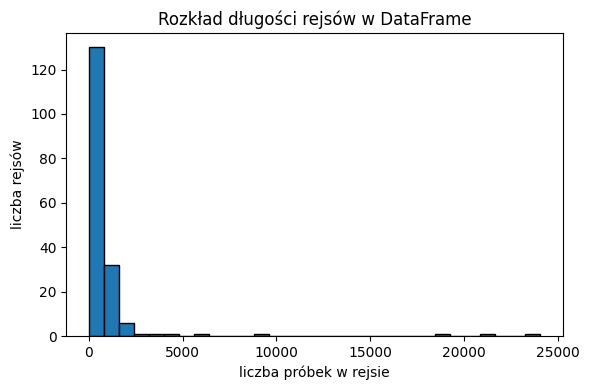

In [ ]:
cruise_lengths = (
    df.groupby("cruise")
      .size()
      .sort_values(ascending=False)
)

print("Top 10 najdłuższych rejsów:")
print(cruise_lengths.head(10), "\n")

print("Statystyki opisowe (liczba próbek w rejsie):")
print(cruise_lengths.describe())

plt.figure(figsize=(6,4))
plt.hist(cruise_lengths, bins=30, edgecolor="k")
plt.xlabel("liczba próbek w rejsie")
plt.ylabel("liczba rejsów")
plt.title("Rozkład długości rejsów w DataFrame")
plt.tight_layout()
plt.show()

In [37]:
min_len = configs["win"] * 2
df = df.groupby("cruise").filter(lambda g: len(g) >= min_len)

In [38]:

rng = np.random.default_rng(42)
rng.shuffle(unique_cruises)
split = int(len(unique_cruises) * 0.8)
train_ids, test_ids = unique_cruises[:split], unique_cruises[split:]

train_df = df[df["cruise"].isin(train_ids)].copy()
test_df = df[df["cruise"].isin(test_ids)].copy()

t_scaler = StandardScaler()
train_df["dn2o_scaled"] = t_scaler.fit_transform(train_df[["dn2o_ppb"]])
test_df["dn2o_scaled"] = t_scaler.transform(test_df[["dn2o_ppb"]])

for d in (train_df, test_df):
    d["dn2o_known"]       = d["dn2o_scaled"] 
    d["dn2o_known_flag"]  = 1.0

float_cols = [
    "temperature",
    "salinity",
    "depth",
    "atmPressure",
    "month_sin",
    "month_cos",
    "index_in_cruise",
    "dn2o_known"
]
flag_cols  = ["dn2o_known_flag"]
features = float_cols + flag_cols

f_scaler = StandardScaler()
train_df[float_cols] = f_scaler.fit_transform(train_df[float_cols])
test_df[float_cols] = f_scaler.transform(test_df[float_cols])


In [39]:

train_ds = LazyMaskedWindowDataset(train_df, features, win=configs["win"], n_windows=configs["n_windows"], mask_frac=configs["mask_frac"])
val_ds   = LazyMaskedWindowDataset(test_df,  features, win=configs["win"], n_windows=int(configs["n_windows"]*0.25), mask_frac=configs["mask_frac"])
test_ds  = LazyMaskedWindowDataset(test_df,  features, win=configs["win"], n_windows=int(configs["n_windows"]*0.25), mask_frac=configs["mask_frac"])

train_loader = DataLoader(train_ds, batch_size=configs["batch"], shuffle=True, drop_last=True,
                        pin_memory=True, num_workers=configs["num_workers"])
                        
val_loader  = DataLoader(val_ds, batch_size=configs["batch"], shuffle=False,
                        pin_memory=True, num_workers=configs["num_workers"])

test_loader  = DataLoader(test_ds,  batch_size=configs["batch"], shuffle=False,
                        pin_memory=True, num_workers=configs["num_workers"])

In [46]:

rf_features = ["temperature","salinity","depth","atmPressure",
                "month_sin","month_cos","index_in_cruise"]

print("\n==== BASELINE ====")
rmse_rf, r2_rf, rf_model = rf_from_datasets(
        train_ds, val_ds, t_scaler,
        batch=128, n_workers=0,
        n_trees=500)
print(f"RMSE: {rmse_rf:.3f}  R²: {r2_rf:.3f}")


==== BASELINE ====
RMSE: 98.995  R²: -47.277


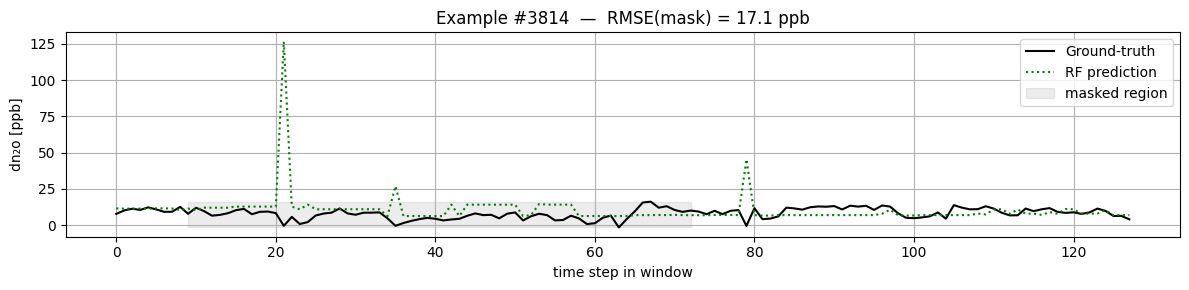

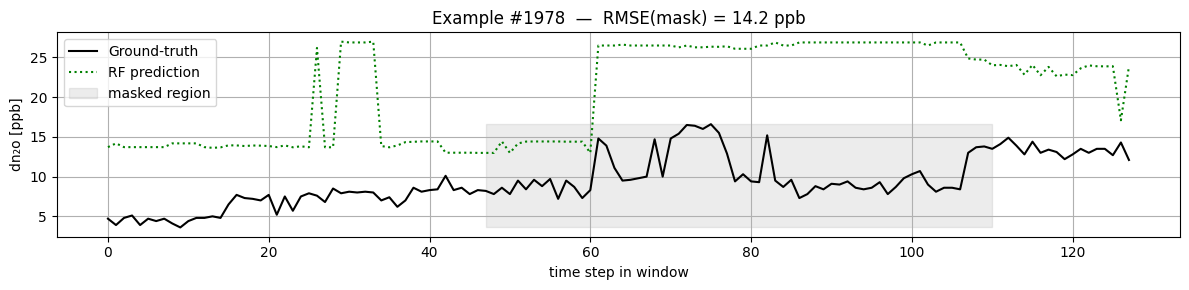

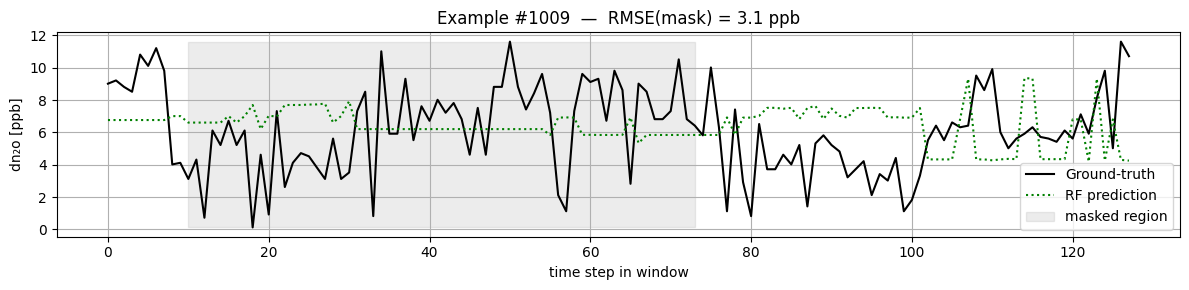

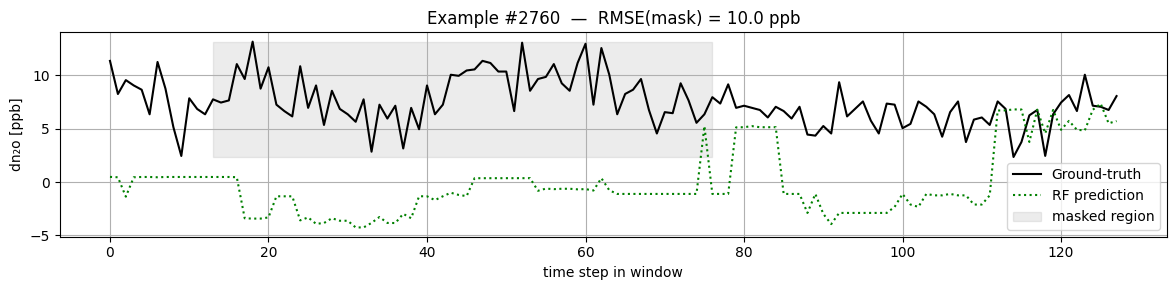

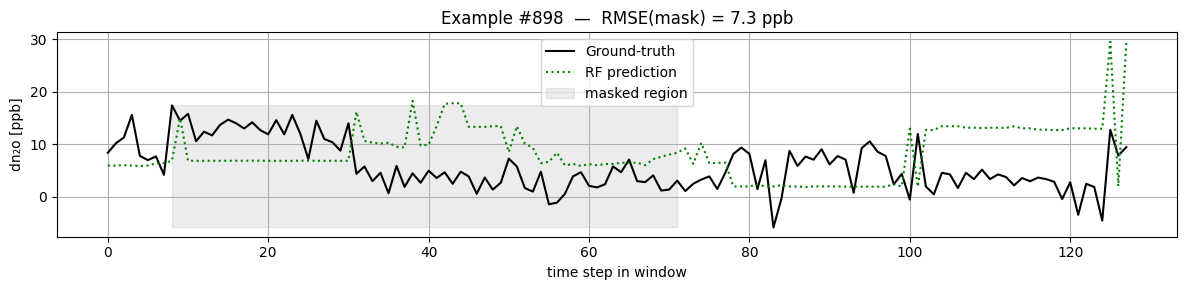

In [ ]:
N_SHOW       = 5
device       = torch.device("cpu")
rf_feat_idx  = [features.index(f) for f in rf_features]

idxs = np.random.choice(len(test_ds), size=N_SHOW, replace=False)

for j, idx in enumerate(idxs, 1):
    x, y_scaled, m = test_ds[idx]
    x = x.to(device)
    T = x.shape[0]
    t = np.arange(T)

    X_rf = x[:, rf_feat_idx].numpy()
    y_pred_scaled = rf_model.predict(X_rf).reshape(-1, 1)
    y_pred_ppb    = t_scaler.inverse_transform(y_pred_scaled).ravel()

    y_true_ppb = t_scaler.inverse_transform(y_scaled.numpy().reshape(-1,1)).ravel()

    mask_np = m.numpy()
    rmse = np.sqrt(((y_true_ppb[mask_np] - y_pred_ppb[mask_np])**2).mean())

    plt.figure(figsize=(12,3))
    plt.plot(t, y_true_ppb, "k-",  label="Ground-truth")
    plt.plot(t, y_pred_ppb, "g:",  label="RF prediction")
    plt.fill_between(t, y_true_ppb.min(), y_true_ppb.max(),
                        where=mask_np, color="gray", alpha=0.15, step="mid",
                        label="masked region")
    plt.title(f"Example #{idx}  —  RMSE(mask) = {rmse:.1f} ppb")
    plt.xlabel("time step in window"); plt.ylabel("dn₂o [ppb]")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [40]:
model = BiLSTMImputer(len(features), hidden=configs["hidden"], layers=configs["layers"]).to(device)
loss_fn = nn.HuberLoss(delta=1.0)
optim = torch.optim.AdamW(model.parameters(), lr=configs["lr"], weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", factor=0.5, patience=10, verbose=False)

for epoch in range(1, configs["epochs"] + 1):
    train_loss = train_epoch(model, train_loader, optim, loss_fn, device, lambda_known=configs["lambda_known"])
    sched.step(train_loss)
    if epoch % 10 == 0 or epoch == 1:
        rmse, r2 = evaluate(model, val_loader, t_scaler, device)
        print(f"Ep {epoch:03d} | loss {train_loss:.4f} | RMSE {rmse:.2f} | R² {r2:.3f}")

rmse, r2 = evaluate(model, test_loader, t_scaler, device)
print("\n==== FINAL TEST ====")
print(f"RMSE: {rmse:.3f}  R²: {r2:.3f}")


Ep 001 | loss 0.1844 | RMSE 24.58 | R² -1.765
Ep 010 | loss 0.0938 | RMSE 14.95 | R² -0.119
Ep 020 | loss 0.0213 | RMSE 12.92 | R² 0.163
Ep 030 | loss 0.0046 | RMSE 12.21 | R² 0.297
Ep 040 | loss 0.0054 | RMSE 12.65 | R² 0.291
Ep 050 | loss 0.0021 | RMSE 13.25 | R² 0.159
Ep 060 | loss 0.0019 | RMSE 13.08 | R² 0.214
Ep 070 | loss 0.0018 | RMSE 12.96 | R² 0.156
Ep 080 | loss 0.0012 | RMSE 13.02 | R² 0.187
Ep 090 | loss 0.0009 | RMSE 13.93 | R² 0.040
Ep 100 | loss 0.0007 | RMSE 13.37 | R² 0.209

==== FINAL TEST ====
RMSE: 12.893  R²: 0.202


In [41]:
N_EXAMPLES = 5
rf_features = ["temperature","salinity","depth","atmPressure",
                "month_sin","month_cos","index_in_cruise"]
model.eval().to(device)

BiLSTMImputer(
  (lstm): LSTM(9, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (proj): Linear(in_features=512, out_features=1, bias=True)
)

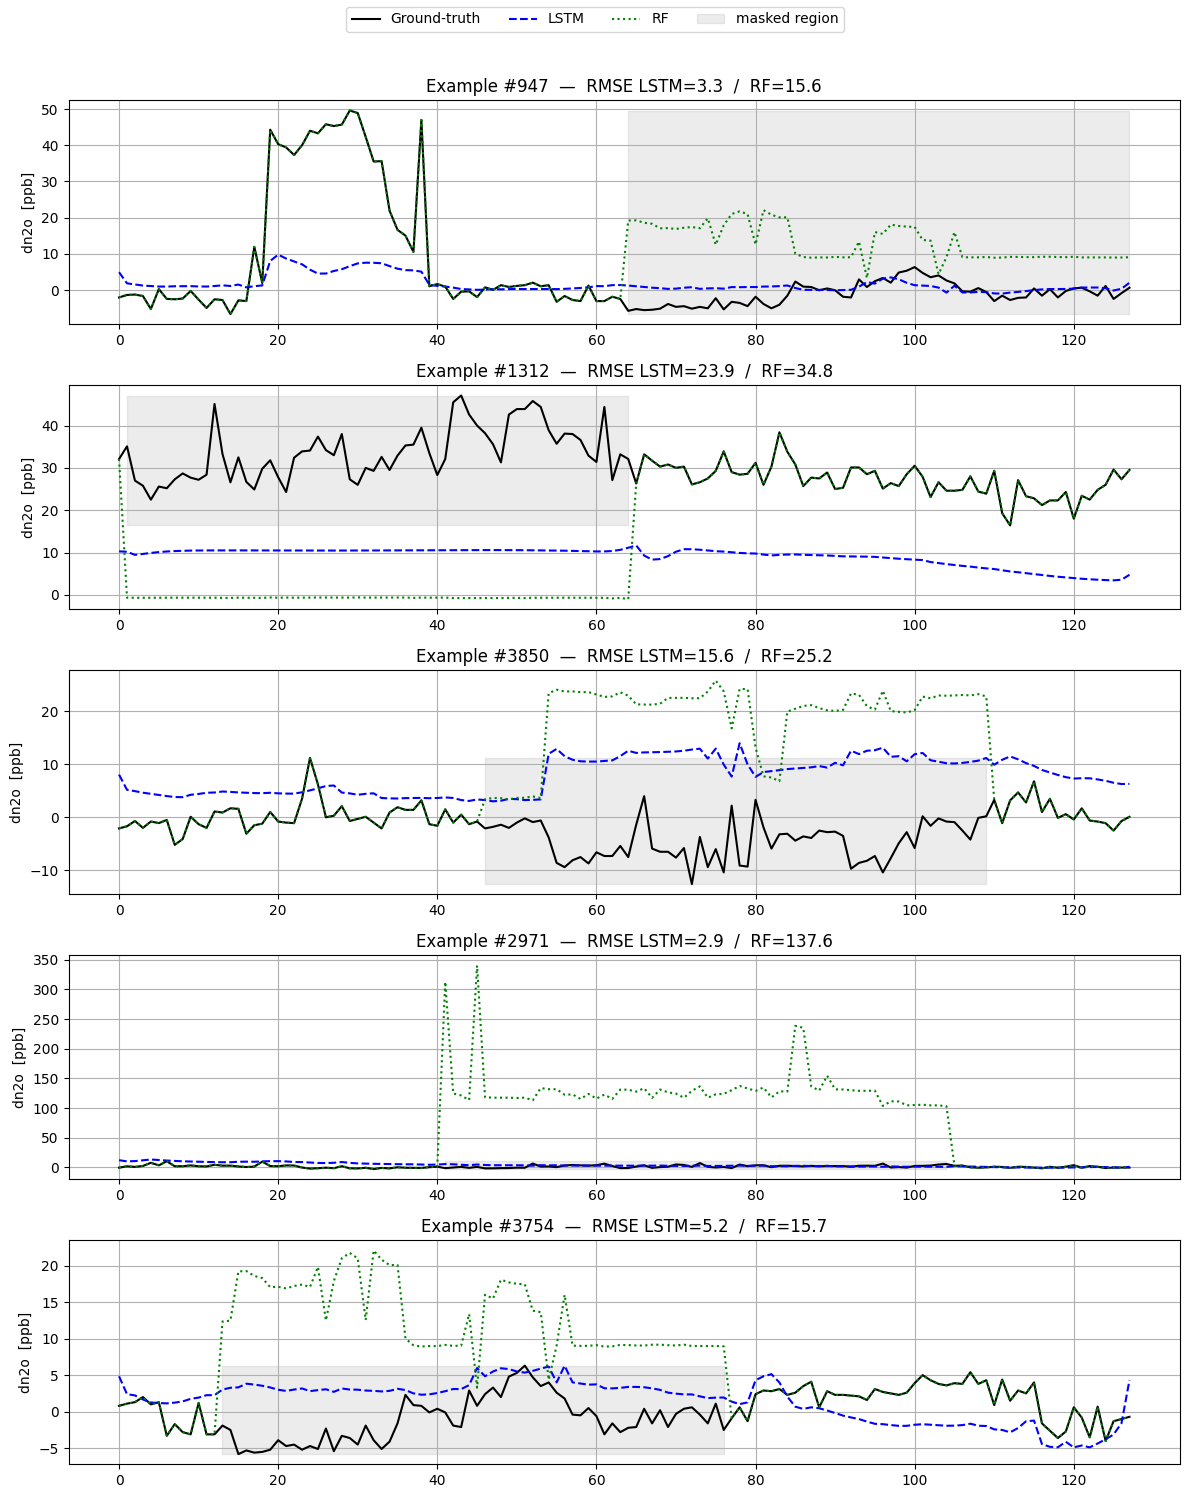

In [ ]:
idxs = np.random.choice(len(test_ds), size=N_EXAMPLES, replace=False)
fig, axes = plt.subplots(N_EXAMPLES, 1, figsize=(12, 3*N_EXAMPLES), sharex=False)
for ax, idx in zip(axes, idxs):
    x, y_scaled, m = test_ds[idx]                 # x:[T,F], y:[T], m:[T]
    x    = x.unsqueeze(0).to(device)              # [1,T,F]
    y_t  = y_scaled.numpy()                       # scaled ground-truth (np)
    mask = m.numpy()                              # bool

    with torch.no_grad():
        y_pred_scaled = model(x).squeeze(0).cpu().numpy()

    x_np      = x.squeeze(0).cpu().numpy()
    X_rf      = x_np[:, :len(rf_features)]
    rf_pred_scaled          = np.copy(y_scaled)
    rf_pred_scaled[mask]    = rf_model.predict(X_rf[mask])

    y_true = t_scaler.inverse_transform(y_t.reshape(-1,1)).ravel()
    y_lstm = t_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    y_rf   = t_scaler.inverse_transform(rf_pred_scaled.reshape(-1,1)).ravel()

    t = np.arange(len(y_true))
    ax.plot(t, y_true, "k-",  label="Ground-truth")
    ax.plot(t, y_lstm, "b--", label="LSTM")
    ax.plot(t, y_rf,  "g:",  label="RF")

    ax.fill_between(t, y_true.min(), y_true.max(),
                    where=mask, color="gray", alpha=0.15, step="mid",
                    label="masked region" if idx==idxs[0] else None)

    ax.set_title(f"Example #{idx}  —  RMSE LSTM={np.sqrt(((y_true-y_lstm)**2)[mask].mean()):.1f}  "
                f"/  RF={np.sqrt(((y_true-y_rf)**2)[mask].mean()):.1f}")
    ax.set_ylabel("dn2o  [ppb]")
    ax.grid(True)

# wspólna legenda
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()